Epoch [0/500]  Loss D: -103095.46875, Loss G: 188409.875
Epoch [1/500]  Loss D: -98966.421875, Loss G: 180341.15625
Epoch [2/500]  Loss D: -85099.296875, Loss G: 144568.21875
Epoch [3/500]  Loss D: -58854.046875, Loss G: 73607.671875
Epoch [4/500]  Loss D: -20858.115234375, Loss G: 4789.1015625
Epoch [5/500]  Loss D: -3991.38330078125, Loss G: -29248.478515625
Epoch [6/500]  Loss D: 883.750732421875, Loss G: -12998.6064453125
Epoch [7/500]  Loss D: 152.12850952148438, Loss G: -5329.2802734375
Epoch [8/500]  Loss D: 31.717382431030273, Loss G: -3639.482666015625
Epoch [9/500]  Loss D: 107.17303466796875, Loss G: -1897.0321044921875
Epoch [10/500]  Loss D: 8.627013206481934, Loss G: -397.1602478027344
Epoch [11/500]  Loss D: 6.608496189117432, Loss G: 43.58314514160156
Epoch [12/500]  Loss D: 3.347719430923462, Loss G: 88.87322235107422
Epoch [13/500]  Loss D: 1.5968482494354248, Loss G: 152.4320526123047
Epoch [14/500]  Loss D: 2.7289466857910156, Loss G: 272.19195556640625
Epoch [15/50

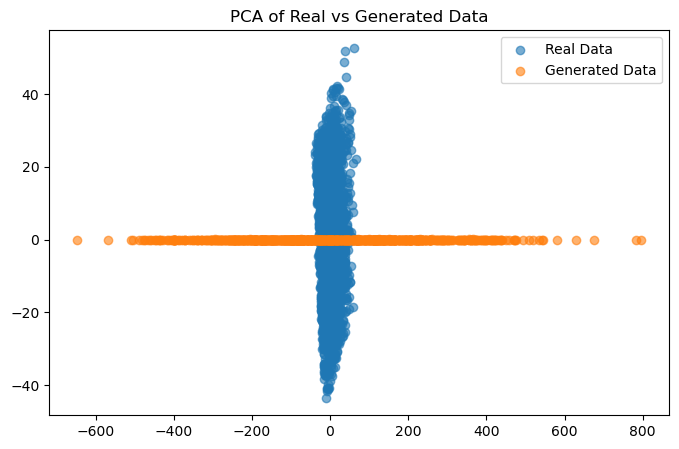

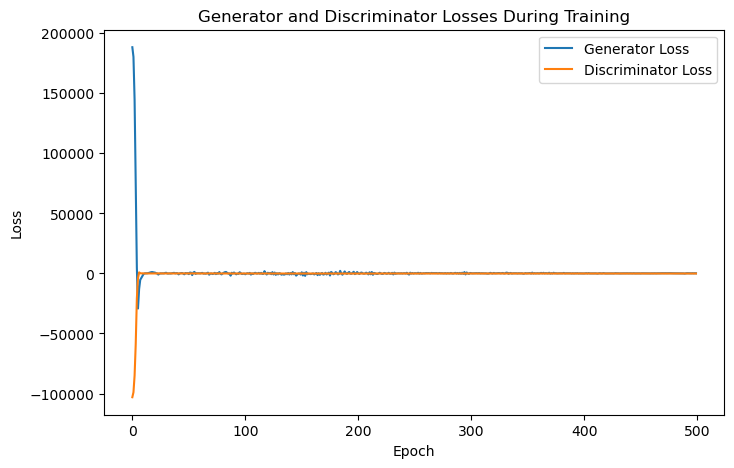

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load and preprocess the dataset
df = pd.read_csv('/Users/farhatlamiabarsha/Downloads/archive/Fraud_Data.csv')
columns_to_drop = ['user_id', 'signup_time', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address']
df.drop(columns=columns_to_drop, axis=1, inplace=True)
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['year'] = df['purchase_time'].dt.year
df['month'] = df['purchase_time'].dt.month
df['day'] = df['purchase_time'].dt.day
df['hour'] = df['purchase_time'].dt.hour
df['minute'] = df['purchase_time'].dt.minute
df['second'] = df['purchase_time'].dt.second
df = df.drop('purchase_time', axis=1)
new_column_order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'purchase_value', 'class']
df = df[new_column_order]
non_fraud = df[df['class'] == 0].sample(df['class'].value_counts()[1])
fraud = df[df['class'] == 1]
df = pd.concat([fraud, non_fraud], ignore_index=True)

# Select a subset of 3000 samples
df_subset = df.sample(3000, random_state=99)

X = df_subset.drop(['class'], axis=1)
y = df_subset['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Define WGAN-GP models
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, output_dim)
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.output_layer(features)
        return output, features

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1).expand_as(real_data)
    interpolates = epsilon * real_data + (1 - epsilon) * fake_data
    interpolates = interpolates.requires_grad_(True)
    d_interpolates, _ = discriminator(interpolates)  
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(interpolates.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Train WGAN-GP
latent_dim = 100
lr = 0.0002
n_epochs = 500
n_critic = 5
lambda_gp = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(latent_dim, X_train.shape[1]).apply(weights_init).to(device)
discriminator = Discriminator(X_train.shape[1]).apply(weights_init).to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

min_loss = float('inf')
min_loss1 = float('inf')

# Lists to store the losses
generator_losses = []
discriminator_losses = []
some_threshold = 0.01

# Function to compute the running mean and standard deviation
def running_mean_std(values, window_size=20):  # Smaller window size
    if len(values) < window_size:
        return np.mean(values), np.std(values)
    recent_values = values[-window_size:]
    return np.mean(recent_values), np.std(recent_values)

# Training loop with dynamic mode collapse detection
window_size = 40  # Reduced window size to detect earlier
collapse_detected = False

# Variables to store the highest generator and discriminator loss observed
max_gen_loss = float('-inf')
max_disc_loss = float('-inf')

# Number of epochs to stabilize the model before starting mode collapse detection
stabilization_epochs = 20

for epoch in range(n_epochs):
    for i, (real_data,) in enumerate(train_loader):
        real_data = real_data.to(device)
        batch_size = real_data.size(0)

        # Train Discriminator
        for _ in range(n_critic):
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z).detach()
            d_real, real_features = discriminator(real_data)
            d_fake, fake_features = discriminator(fake_data)
            gradient_pen = gradient_penalty(discriminator, real_data, fake_data)
            loss_D = d_fake.mean() - d_real.mean() + lambda_gp * gradient_pen
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

        # Train Generator with Feature Matching
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(z)
        d_fake, fake_features = discriminator(fake_data)
        d_real, real_features = discriminator(real_data)

        # Feature matching loss
        feature_matching_loss = torch.mean(torch.abs(torch.mean(fake_features, 0) - torch.mean(real_features, 0)))

        # Adjust the loss balancing
        feature_matching_weight = 10  # Adjust this weight as needed
        loss_G = -d_fake.mean() + feature_matching_weight * feature_matching_loss

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store the losses
    generator_losses.append(loss_G.item())
    discriminator_losses.append(loss_D.item())

    print(f"Epoch [{epoch}/{n_epochs}]  Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

    # Update the highest generator and discriminator loss seen so far
    if loss_G.item() > max_gen_loss:
        max_gen_loss = loss_G.item()
    if loss_D.item() > max_disc_loss:
        max_disc_loss = loss_D.item()

    # Mode collapse detection starts after the stabilization period
    if epoch > stabilization_epochs:
        # Mode collapse detection: If the current loss exceeds half of the maximum observed loss
        if loss_G.item() > 0.5 * max_gen_loss or loss_D.item() > 0.5 * max_disc_loss:
            print(f"Mode collapse alert at epoch {epoch}: Loss G: {loss_G.item()}, Loss D: {loss_D.item()}")
            collapse_detected = True
            break

    # Break if mode collapse is detected
    if collapse_detected:
        break

# Check if mode collapse was not detected
if not collapse_detected:
    print("No mode collapse detected during training.")
    
# Generate new data
generator.eval()
z = torch.randn(1000, latent_dim).to(device)
generated_data = generator(z).detach().cpu().numpy()

# PCA Visualization
def plot_pca(real_data, generated_data, title):
    pca = PCA(n_components=2)
    real_data_pca = pca.fit_transform(real_data)
    generated_data_pca = pca.fit_transform(generated_data)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], label='Real Data', alpha=0.6)
    plt.scatter(generated_data_pca[:, 0], generated_data_pca[:, 1], label='Generated Data', alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot PCA
plot_pca(X_train.values, generated_data, 'PCA of Real vs Generated Data')

# Plot the generator and discriminator losses
plt.figure(figsize=(8, 5))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.title('Generator and Discriminator Losses During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

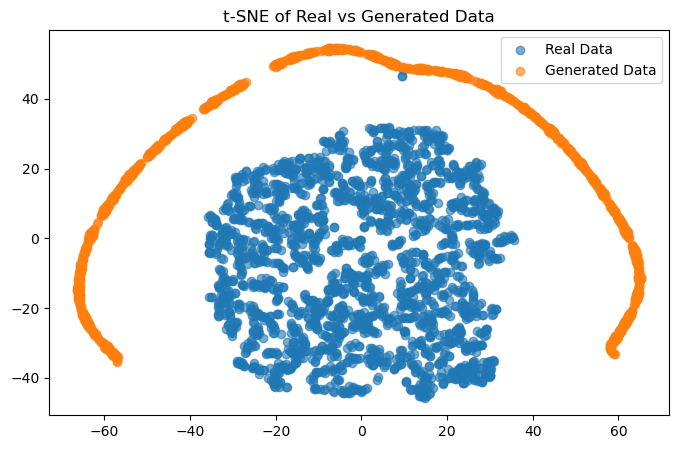

In [8]:
def plot_tsne(real_data, generated_data, title):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=99)
    
    combined_data = np.concatenate([real_data, generated_data])
    tsne_results = tsne.fit_transform(combined_data)
    
    real_tsne = tsne_results[:real_data.shape[0]]
    generated_tsne = tsne_results[real_data.shape[0]:]

    plt.figure(figsize=(8, 5))
    plt.scatter(real_tsne[:, 0], real_tsne[:, 1], label='Real Data', alpha=0.6)
    plt.scatter(generated_tsne[:, 0], generated_tsne[:, 1], label='Generated Data', alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot t-SNE visualization of real vs generated data
plot_tsne(X_train.values, generated_data, 't-SNE of Real vs Generated Data')